In [3]:
%load_ext autoreload
%autoreload 2

import random
import numpy as np
import os
import pickle
import lzma
import torch
from metadrive import MetaDriveEnv
from concurrent.futures import ProcessPoolExecutor
from env import State, Observation, Action, next_state, normalize_angle, get_metadrive_state, state_batch_to_tensor, action_batch_to_tensor
from metadrive_model import MetadriveModel, metadrive_model_train_batch
from model_utils import set_lr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def gen_random_state_action() -> tuple[State, Action]:
    """
    Generates a random state with probabilities that are similar to that are found in the waymo dataset
    """
    if np.random.rand() < 0.5:
        # parked 
        vel = np.random.normal(0, 0.01, 2)
        heading = np.random.uniform(-np.pi, np.pi)
        action = np.random.normal(0, 0.01, 2)
    else:
        # moving
        vel = np.random.normal(0, 20, 2)
        heading = normalize_angle(np.arctan2(vel[1], vel[0]) + np.random.normal(0, 0.2))
        action = np.random.uniform(-1, 1, 2)

    return State(heading=heading, velocity=vel), tuple(action)

def generate_data(n: int) -> list[tuple[State, Action, State]]:
    env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})
    dataset: list[tuple[State, Action, State]] = []
    for _ in range(n):
        s0, a = gen_random_state_action()
        s1 = next_state(env, s0, a)
        dataset.append((s0, a, s1))
    env.close()
    return dataset

In [5]:
NUM_SCENARIOS = 500_000
MAX_WORKERS = 16

mm_data: list[tuple[State, Action, State]] = []

with ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
    batch_size, leftover_size = divmod(NUM_SCENARIOS, MAX_WORKERS)
    
    # Distribute the data evenly among workers
    n_scenarios_per_worker = [batch_size]*MAX_WORKERS
    for i in range(leftover_size):
        n_scenarios_per_worker[i] += 1

    # Generate the data in parallel
    for batch in executor.map(generate_data, n_scenarios_per_worker):
        mm_data.extend(batch)

[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: []
[INFO] MetaDrive version: 0.4.1.2
[INFO] Render Mode: none
[INFO] Sensors: []
[INFO] Sensors: []
[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: []
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: []
[INFO] Sensors: []
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: []
[INFO] MetaDrive version: 0.4.1.2
[INFO] Render Mode: none
[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: []
[INFO] Render Mode: none
[INFO] Render Mode: none
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] Render Mode: none
[INFO] Sensors: []
[INFO] Render Mode: none
[INFO] Sensors: []
[INFO] Render Mode: none
[INFO] Sensors: []
[INFO] Sensors: []
[INFO] Sensors: []
[INFO] Render Mode: none
[INFO] Se

In [7]:
# save data
if not os.path.exists("./data/mm_data.pkl.xz"):
    with lzma.open("./data/mm_data.pkl.xz", "wb") as f:
        pickle.dump(mm_data, f)

In [45]:
# load data
if not "mm_data2" in locals():
    with lzma.open("./data/mm_data.pkl.xz", "rb") as f:
        mm_data2: list[tuple[State, Action, State]] = pickle.load(f)

In [11]:
# 90:10 train-validation split
random.seed(0)
random.shuffle(mm_data)
mm_train_data = mm_data[:int(len(mm_data)*0.9)]
mm_validation_data = mm_data[int(len(mm_data)*0.9):]

In [15]:
print("train data size:", len(mm_train_data))
print("validation data size:", len(mm_validation_data))

train data size: 450000
validation data size: 50000


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
import itertools
# make sure we don't run out of data
mm_train_iter = itertools.cycle(mm_train_data)

mm = MetadriveModel().to(device)

mm_optimizer = torch.optim.AdamW(mm.parameters())

mm_step = 0
mm_losses = []

In [38]:
set_lr(mm_optimizer, 1e-4)
METADRIVE_MODEL_TRAIN_EPOCHS = 20000
METADRIVE_MODEL_TRAIN_BATCH_SIZE = 8192

while mm_step < METADRIVE_MODEL_TRAIN_EPOCHS:
    # take up to n from the data buffer
    s0_batch = []
    a_batch = []
    s1_batch = []
    for _ in range(METADRIVE_MODEL_TRAIN_BATCH_SIZE):
        s0, a, s1 = next(mm_train_iter)
        s0_batch.append(s0)
        a_batch.append(a)
        s1_batch.append(s1)

    # train
    loss = metadrive_model_train_batch(mm, mm_optimizer, s0_batch, a_batch, s1_batch)
    mm_losses.append(loss)
    mm_step += 1
    if mm_step % 500 == 0:
        # print average loss over the last 500 steps
        loss = np.mean(mm_losses[-500:])
        print(f"Step: {mm_step}, Loss: {loss:.4f}")

Step: 15500, Loss: 0.0047
Step: 16000, Loss: 0.0046
Step: 16500, Loss: 0.0044
Step: 17000, Loss: 0.0044
Step: 17500, Loss: 0.0042
Step: 18000, Loss: 0.0040
Step: 18500, Loss: 0.0040
Step: 19000, Loss: 0.0039
Step: 19500, Loss: 0.0036
Step: 20000, Loss: 0.0036


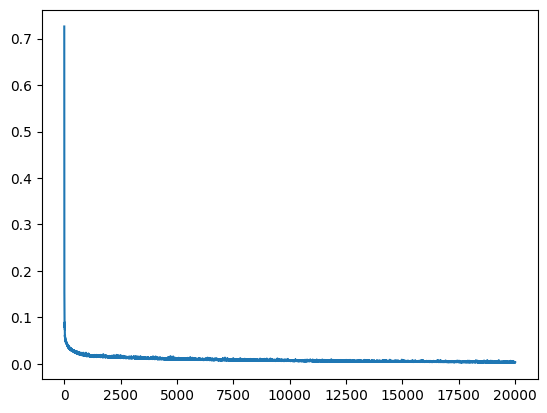

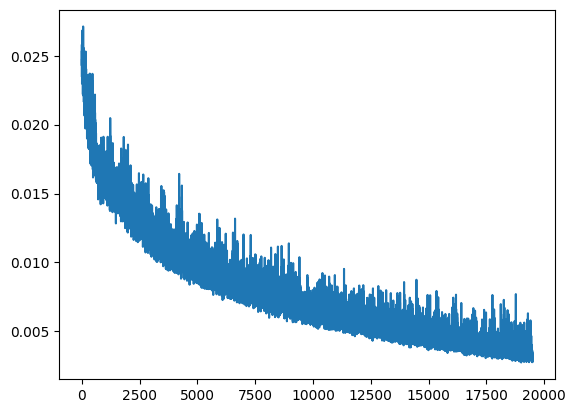

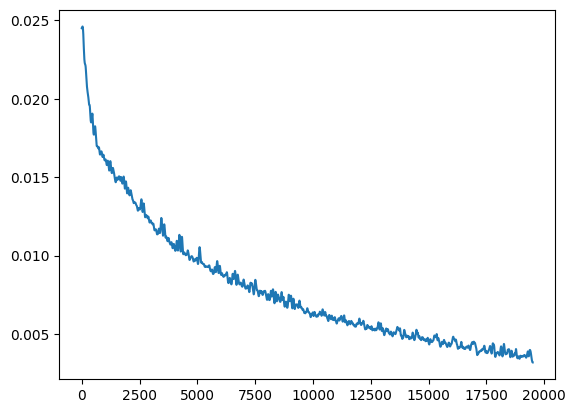

In [39]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d


# Plot the losses over training
plt.plot(list(range(len(mm_losses))), mm_losses, label='MM')
plt.show()

latter_training = mm_losses[500:]
plt.plot(list(range(len(latter_training))), latter_training, label='MM')
plt.show()

# denoise
latter_training_denoised = gaussian_filter1d(latter_training, sigma=20)
plt.plot(list(range(len(latter_training_denoised))), latter_training_denoised, label='MM')
plt.show()

In [ ]:
# load mm
if 'mm' not in locals():
    mm = MetadriveModel().to(device)
    mm.load_state_dict(torch.load('data/mm.pth'))

In [50]:
# save mm
if not os.path.exists('data/mm.pth'):
    torch.save(mm.state_dict(), 'data/mm.pth')

In [40]:
s0_batch = [s0 for s0, _, _ in mm_train_data]
s1_batch = [s1 for _, _, s1 in mm_train_data]
a_batch = [a for _, a, _ in mm_train_data]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = mm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0]
loss_y = loss[:, 1]
loss_theta = loss[:, 2] + loss[:, 3]

print("training loss", loss.mean().item())

training loss 0.003554682247340679


In [41]:
s0_batch = [s0 for s0, _, _ in mm_validation_data]
s1_batch = [s1 for _, _, s1 in mm_validation_data]
a_batch = [a for _, a, _ in mm_validation_data]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = mm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0]
loss_y = loss[:, 1]
loss_theta = loss[:, 2] + loss[:, 3]

print("validation loss", loss.mean().item())

validation loss 0.0035764009226113558


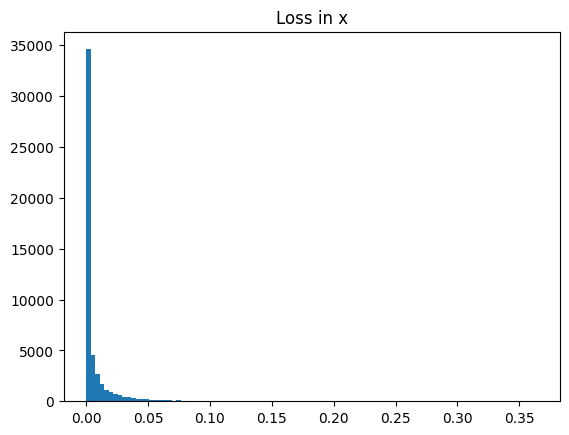

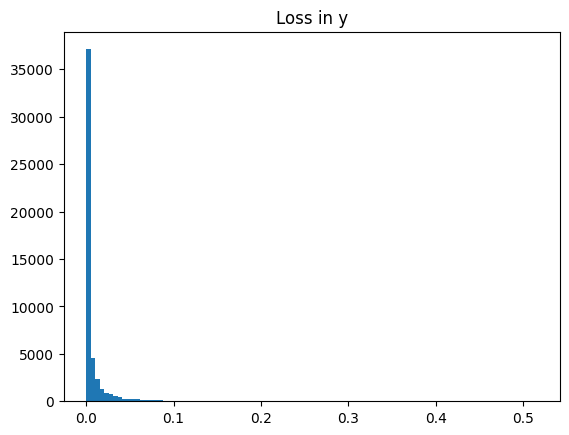

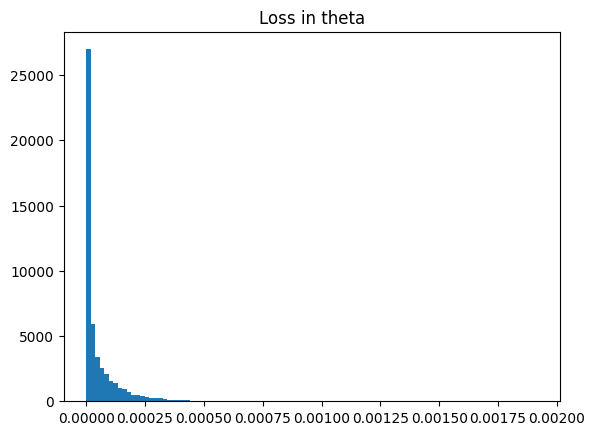

In [42]:
plt.hist(loss_x.cpu().detach().numpy(), bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y.cpu().detach().numpy(), bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta.cpu().detach().numpy(), bins=100)
plt.title('Loss in theta')
plt.show()